<a href="https://colab.research.google.com/github/silviolima07/Kaggle-Colab/blob/main/Analise_Viagens_Onibus_Pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=119CJM4EnZ5XDikTz6_evjINNJBz9pt_2)

# Referencias:
- https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
- https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb
- https://towardsdatascience.com/introduction-to-regression-in-python-with-pycaret-d6150b540fc4
- https://www.flai.com.br/jonatas/previsao-de-series-temporais-com-prophet/
- https://www.kaggle.com/code/tientd95/advanced-pyspark-for-exploratory-data-analysis
- https://pub.towardsai.net/exploratory-data-analysis-eda-using-pyspark-b43e71fcec9f
- https://medium.com/@aieeshashafique/exploratory-data-analysis-using-pyspark-dataframe-in-python-bd55c02a2852

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Foram usados dados do Kaggle.
# Colunas foram selecionadas priorizando aquelas que podem ajudar entender o fluxo de bilhetes emitidos no ano de 2019.

# Objetivos:
- Quais as 5 cidades mais visitadas no país?
- Quais os meses com maior fluxo de viajantes?
- Quais os dias da semana que mais emitiram bilhetes?
- Quais os 10 Estados que mais emitiram bilhetes?
- Qual o fluxo de viajantes entre Estados?
- Prever o fluxo de bilhetes emitidos com destino a SAO PAULO/SP.

# Dados usados:
- passagens/viagens - https://www.kaggle.com/datasets/danlessa/brazil-interstate-bus-travels?resource=download

In [2]:
!pip install pyspark --q
!pip install pySankey --q

In [3]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

In [4]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib

from pySankey.sankey import sankey

from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [5]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, to_date, \
dayofweek, sum,avg,max,min,mean,count, trim, udf
from pyspark.sql.types import *
from pyspark.sql.functions import month
from pyspark.sql.functions import to_timestamp,date_format
from pyspark.sql.functions import col
from pyspark.sql.functions import count



MAX_MEMORY = '10G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

In [6]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
def trim(string):
    return string.strip()

In [8]:
def lineplot(df, title,x, y,figname):

    '''
    This function makes a line plot from Spark dataframe df with
    independent variable x and averaged over y.
    '''
    plt.figure(figsize=(20,10))
    df.plot(x, y, legend=False);

    plt.title(title)
    plt.ylabel(y)
    plt.savefig(figname, bbox_inches='tight')
    plt.show()


# Leitura dos dados de 2019

In [9]:
df_03_2019 =  spark.read.options(header='True', inferSchema='True',delimiter=';').csv("/content/drive/MyDrive/Viagens/venda_passagem_03_2019/venda_passagem_03_2019.csv")
#
df_11_2019 =  spark.read.options(header='True', inferSchema='True',delimiter=';').csv("/content/drive/MyDrive/Viagens/venda_passagem_11_2019/venda_passagem_11_2019.csv")
#
df_12_2019 =  spark.read.options(header='True', inferSchema='True',delimiter=';').csv("/content/drive/MyDrive/Viagens/venda_passagem_12_2019/venda_passagem_12_2019.csv")

In [10]:
result1 = df_03_2019.union(df_11_2019)
df_full = result1.union(df_12_2019)

# Dataset completo: 6035180 registros.

In [11]:
print("Total registros:",df_full.count())

Total registros: 6035180


In [12]:
df_full.show(5)

+-------------+--------------+-------------------------+--------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+-----------+-------------------+-----------+---------------+-------------------+--------------------+------------+-------------------------+-------------------+-------------+-------------------+-----------+--------------+---------------------+
|codigo_viagem|          cnpj|numero_equipamento_fiscal|numero_bilhete|data_emissao_bilhete|hora_emissao_bilhete|categoria_transporte|nu_linha|origem_destino_linha| ponto_origem_viagem|ponto_destino_viagem|        tipo_servico|data_viagem|        hora_viagem|tipo_viagem|numero_poltrona|plataforma_embarque|      tipo_gratitude|valor_tarifa|valor_percentual_desconto|valor_aliquota_icms|valor_pedagio|valor_taxa_embarque|valor_total|origem_emissao|in_passagem_cancelada|
+-------------+--------------+-------------------------+--

In [13]:
print('Data overview')
df_full.printSchema()
print('Columns overview')
pd.DataFrame(df_full.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- codigo_viagem: integer (nullable = true)
 |-- cnpj: long (nullable = true)
 |-- numero_equipamento_fiscal: string (nullable = true)
 |-- numero_bilhete: integer (nullable = true)
 |-- data_emissao_bilhete: string (nullable = true)
 |-- hora_emissao_bilhete: timestamp (nullable = true)
 |-- categoria_transporte: string (nullable = true)
 |-- nu_linha: integer (nullable = true)
 |-- origem_destino_linha: string (nullable = true)
 |-- ponto_origem_viagem: string (nullable = true)
 |-- ponto_destino_viagem: string (nullable = true)
 |-- tipo_servico: string (nullable = true)
 |-- data_viagem: string (nullable = true)
 |-- hora_viagem: timestamp (nullable = true)
 |-- tipo_viagem: string (nullable = true)
 |-- numero_poltrona: integer (nullable = true)
 |-- plataforma_embarque: string (nullable = true)
 |-- tipo_gratitude: string (nullable = true)
 |-- valor_tarifa: double (nullable = true)
 |-- valor_percentual_desconto: string (nullable = true)
 |-- valor_aliquota_

,Column Name,Data type
0,codigo_viagem,int
1,cnpj,bigint
2,numero_equipamento_fiscal,string
3,numero_bilhete,int
4,data_emissao_bilhete,string
5,hora_emissao_bilhete,timestamp
6,categoria_transporte,string
7,nu_linha,int
8,origem_destino_linha,string
9,ponto_origem_viagem,string


# Foram selecionadas as colunas que podem contribuir para entender o fluxo de viagens.

In [14]:
usecols = ['data_emissao_bilhete', 'categoria_transporte', 'origem_destino_linha', 'ponto_origem_viagem',
       'ponto_destino_viagem','tipo_servico', 'data_viagem', 'tipo_gratitude',
       'tipo_viagem', 'numero_poltrona', 'valor_total', 'in_passagem_cancelada']

In [15]:
df_viagem = df_full.select(*usecols)

In [16]:
df_viagem.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-----------+---------------+-----------+---------------------+
|data_emissao_bilhete|categoria_transporte|origem_destino_linha| ponto_origem_viagem|ponto_destino_viagem|        tipo_servico|data_viagem|      tipo_gratitude|tipo_viagem|numero_poltrona|valor_total|in_passagem_cancelada|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+-----------+---------------+-----------+---------------------+
|          21-03-2019|       Interestadual|FLORIANOPOLIS(SC)...|JOINVILLE/SC        |SAO PAULO/SP        |Convencional com ...| 30-03-2019|Tarifa Normal - s...|    Regular|              2|      229.9|                  N�O|
|          15-03-2019|       Interestadual|FLORIANOPOLIS(SC)...|BALNEARIO PICARRA...|SAO PAULO/SP        |Co

In [17]:
print('Data overview')
#df_viagem.printSchema()
print('Columns overview')
pd.DataFrame(df_viagem.dtypes, columns = ['Column Name','Data type'])

Data overview
Columns overview


,Column Name,Data type
0,data_emissao_bilhete,string
1,categoria_transporte,string
2,origem_destino_linha,string
3,ponto_origem_viagem,string
4,ponto_destino_viagem,string
5,tipo_servico,string
6,data_viagem,string
7,tipo_gratitude,string
8,tipo_viagem,string
9,numero_poltrona,int


# Um onibus de 2 andares tem no maximo 104 lugares.
# Registros com valores acima serão excluidos.

In [18]:
df_viagem.groupBy('numero_poltrona').count().orderBy('numero_poltrona',ascending=False).show()

+---------------+-----+
|numero_poltrona|count|
+---------------+-----+
|            599|  293|
|            598|  263|
|            597|  179|
|            596|  102|
|            595|   51|
|            594|   28|
|            593|   12|
|            592|    6|
|            591|    3|
|            590|    1|
|            239|  266|
|            238|  301|
|            237|  232|
|            236|  128|
|            235|   76|
|            234|   39|
|            233|   17|
|            232|   10|
|            231|    4|
|            230|    2|
+---------------+-----+
only showing top 20 rows



In [19]:
df_viagem = df_viagem.filter(df_viagem.numero_poltrona <= 104)

# Converter campo string para data.
- data_emissao_bilhete
- data_viagem

In [20]:
print('Data overview')
#df_viagem.printSchema()
print('Columns overview')
pd.DataFrame(df_viagem.dtypes, columns = ['Column Name','Data type'])

Data overview
Columns overview


,Column Name,Data type
0,data_emissao_bilhete,string
1,categoria_transporte,string
2,origem_destino_linha,string
3,ponto_origem_viagem,string
4,ponto_destino_viagem,string
5,tipo_servico,string
6,data_viagem,string
7,tipo_gratitude,string
8,tipo_viagem,string
9,numero_poltrona,int


In [21]:
df_viagem1 = df_viagem.withColumn('data_emissao_bilhete',to_date(df_viagem.data_emissao_bilhete, 'dd-MM-yyyy'))
df_viagem2 = df_viagem1.withColumn('data_viagem',to_date(df_viagem1.data_viagem, 'dd-MM-yyyy'))

In [22]:
print('Data overview')
#df_viagem.printSchema()
print('Columns overview')
pd.DataFrame(df_viagem2.dtypes, columns = ['Column Name','Data type'])

Data overview
Columns overview


,Column Name,Data type
0,data_emissao_bilhete,date
1,categoria_transporte,string
2,origem_destino_linha,string
3,ponto_origem_viagem,string
4,ponto_destino_viagem,string
5,tipo_servico,string
6,data_viagem,date
7,tipo_gratitude,string
8,tipo_viagem,string
9,numero_poltrona,int


# Identificar dados ausentes.

In [23]:
string_cols = [c for c, t in df_viagem2.dtypes if t =='string']
numeric_columns = ['valor_total','numero_poltrona']
missing_values = {}
size=len(df_viagem2.columns)
for index, column in enumerate(df_viagem2.columns):
    if column in string_cols:    # check string columns with None and Null values
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        print('--',column)
        missing_count = df_viagem2.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        print('--',column)
        missing_count = df_viagem2.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

-- categoria_transporte
-- origem_destino_linha
-- ponto_origem_viagem
-- ponto_destino_viagem
-- tipo_servico
-- tipo_gratitude
-- tipo_viagem
-- numero_poltrona
-- valor_total
-- in_passagem_cancelada


,categoria_transporte,origem_destino_linha,ponto_origem_viagem,ponto_destino_viagem,tipo_servico,tipo_gratitude,tipo_viagem,numero_poltrona,valor_total,in_passagem_cancelada
0,0,0,0,0,0,9,0,0,0,0


# Eliminar linhas com dados ausentes.

In [24]:

df_viagem2 = df_viagem2.na.drop()

# Remover espaços nas colunas tipo string.

In [25]:
string_cols = [c for c, t in df_viagem2.dtypes if t =='string']
from pyspark.sql import functions as f

for colname in string_cols:

    temp1 = df_viagem2.withColumn(colname, f.trim(f.col(colname)))
    temp2 = temp1.withColumn(colname, f.ltrim(f.col(colname)))
    df_viagem2 = temp2.withColumn(colname, f.rtrim(f.col(colname)))

# Extrair dos campos data, as informações de dia, mês e ano.

In [26]:
df_data1 = df_viagem2.withColumn('mes_emissao',month(df_viagem2.data_emissao_bilhete))
df_data1 = df_data1.withColumn("data_emissao_bilhete",to_timestamp(col("data_emissao_bilhete"))).withColumn("dia_emissao", date_format(col("data_emissao_bilhete"), "d"))
df_data1 = df_data1.withColumn("data_emissao_bilhete",to_timestamp(col("data_emissao_bilhete"))).withColumn("ano_emissao", date_format(col("data_emissao_bilhete"), "y"))
#
df_data2 = df_data1.withColumn('mes_viagem',month(df_data1.data_viagem))
df_data2 = df_data2.withColumn("data_viagem",to_timestamp(col("data_viagem"))).withColumn("dia_viagem", date_format(col("data_viagem"), "d"))
df_viagem2 = df_data2.withColumn("data_viagem",to_timestamp(col("data_viagem"))).withColumn("ano_viagem", date_format(col("data_viagem"), "y"))
#
print('df_viagem2')
df_viagem2.select(col("data_emissao_bilhete"), col('mes_emissao'), col('dia_emissao'), col('ano_emissao')).show(3)
df_viagem2.select(col("data_viagem"), col('mes_viagem'), col('dia_viagem'), col('ano_viagem')).show(3)
#

df_viagem2 = df_viagem2.withColumn('dia_da_semana',dayofweek(df_viagem2.data_viagem))
df_viagem2.select(col("data_viagem"), col('dia_da_semana')).show(3)

df_viagem2
+--------------------+-----------+-----------+-----------+
|data_emissao_bilhete|mes_emissao|dia_emissao|ano_emissao|
+--------------------+-----------+-----------+-----------+
| 2019-03-21 00:00:00|          3|         21|       2019|
| 2019-03-15 00:00:00|          3|         15|       2019|
| 2019-03-05 00:00:00|          3|          5|       2019|
+--------------------+-----------+-----------+-----------+
only showing top 3 rows

+-------------------+----------+----------+----------+
|        data_viagem|mes_viagem|dia_viagem|ano_viagem|
+-------------------+----------+----------+----------+
|2019-03-30 00:00:00|         3|        30|      2019|
|2019-03-17 00:00:00|         3|        17|      2019|
|2019-03-06 00:00:00|         3|         6|      2019|
+-------------------+----------+----------+----------+
only showing top 3 rows

+-------------------+-------------+
|        data_viagem|dia_da_semana|
+-------------------+-------------+
|2019-03-30 00:00:00|            

# Serão consideradas as viagens cujos bilhetes foram emitidos no ano de 2019, pois em 2020 começou a pandemia e as restrições de deslocamento provavelmente impactaram nos dados.
# Foram excluidas as linhas onde a coluna in_passagem_cancelada não era igual a NAO.

In [27]:
print("Total registros:",df_viagem2.count())

Total registros: 6033158


In [28]:
df_viagem3 = df_viagem2.filter(df_viagem2.ano_emissao == 2019)

In [29]:
print("Total registros:",df_viagem3.count())

Total registros: 6028785


In [30]:
df_viagem3.groupBy('in_passagem_cancelada').count().orderBy('count').show()

+---------------------+-------+
|in_passagem_cancelada|  count|
+---------------------+-------+
|                  SIM|   3480|
|                  N�O|6025305|
+---------------------+-------+



In [31]:
df_viagem_2019 = df_viagem3.filter(df_viagem3.in_passagem_cancelada == 'N�O')

In [32]:
df_viagem_2019.drop(col("in_passagem_cancelada"))

DataFrame[data_emissao_bilhete: timestamp, categoria_transporte: string, origem_destino_linha: string, ponto_origem_viagem: string, ponto_destino_viagem: string, tipo_servico: string, data_viagem: timestamp, tipo_gratitude: string, tipo_viagem: string, numero_poltrona: int, valor_total: double, mes_emissao: int, dia_emissao: string, ano_emissao: string, mes_viagem: int, dia_viagem: string, ano_viagem: string, dia_da_semana: int]

In [33]:
print("Total registros de viagens em 2019:",df_viagem_2019.count())

Total registros de viagens em 2019: 6025305


# Ranking dos 5 destinos mais visitados

In [34]:
ranking_destinos = df_viagem_2019.select(df_viagem_2019.ponto_destino_viagem) \
    .groupBy(df_viagem_2019.ponto_destino_viagem) \
    .count() \
    .orderBy("count", ascending=False)

In [35]:
# Top 5
top5_destino = ranking_destinos.limit(5).toPandas()
# Caculate the total users, we will this result to compute percentage later
total_trips = ranking_destinos.groupBy().sum().collect()[0][0]

In [36]:
top5_destino

,ponto_destino_viagem,count
0,SAO PAULO/SP,797367
1,RIO DE JANEIRO/RJ,486330
2,CURITIBA/PR,292208
3,BELO HORIZONTE/MG,230278
4,GOIANIA/GO,128398


In [37]:
# top5_destino2 = top5_destino.copy()
top5_destino['percentual'] = np.round(top5_destino['count'] \
    / total_trips * 100,2)

In [38]:
top5_destino

,ponto_destino_viagem,count,percentual
0,SAO PAULO/SP,797367,13.23
1,RIO DE JANEIRO/RJ,486330,8.07
2,CURITIBA/PR,292208,4.85
3,BELO HORIZONTE/MG,230278,3.82
4,GOIANIA/GO,128398,2.13




2019
Top 5 destinos

   ponto_destino_viagem  percentual
0         SAO PAULO/SP       13.23
1    RIO DE JANEIRO/RJ        8.07
2          CURITIBA/PR        4.85
3    BELO HORIZONTE/MG        3.82
4           GOIANIA/GO        2.13
5      Outros Destinos       67.90


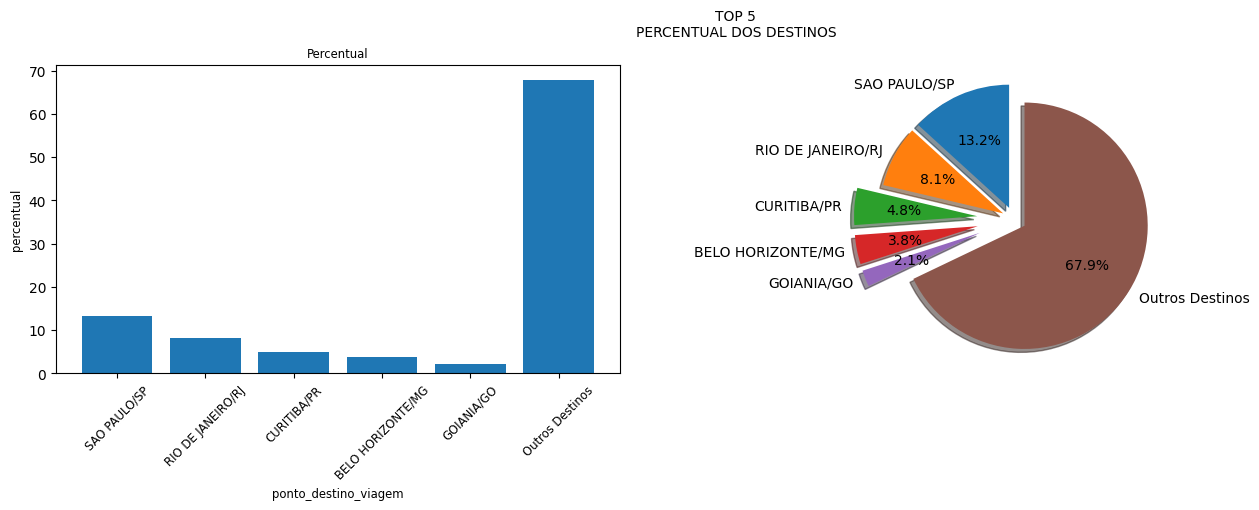

In [39]:
# Compute the percentage of top 5
temp_fig1 = top5_destino.copy()
#temp_fig1['percentual'] = np.round(temp_fig1['count'] \
#    / total_trips * 100,2)

outros = {
      'ponto_destino_viagem': 'Outros Destinos'
    , 'count': total_trips - np.sum(temp_fig1['count'])
    , 'percentual': 100 - np.sum(temp_fig1['percentual'])
}
temp_fig1 = temp_fig1.append(
    outros, ignore_index=True
)

temp_fig1 = temp_fig1[['ponto_destino_viagem', 'percentual']]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.25))

plot0 =   axs[0].bar(x=temp_fig1['ponto_destino_viagem']
                     , height=temp_fig1['percentual'])
title0 =  axs[0].set_title('Percentual', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('ponto_destino_viagem', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('percentual', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(temp_fig1['ponto_destino_viagem']
                                       ,rotation = 45, fontsize='small')

explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
#title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=temp_fig1['percentual']
    , labels=temp_fig1['ponto_destino_viagem']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
);

text = fig.text(0.55, 1.02, 'TOP 5\nPERCENTUAL DOS DESTINOS', ha='center', va='top', transform=fig.transFigure);
print('\033[1m'+'\n\n2019\nTop 5 destinos\n\n',temp_fig1)
#
plt.savefig("Fig1.png", bbox_inches='tight')

# Datas com mais bilhetes emitidos.

In [40]:
# Remover o timestamp da coluna data_emisssao_bilhete
df_viagem_2019= df_viagem_2019.withColumn('data_emissao', to_date(col('data_emissao_bilhete')))

In [41]:
ranking_data_emissao = df_viagem_2019.select(df_viagem_2019.data_emissao) \
    .groupBy(df_viagem_2019.data_emissao) \
    .count() \
    .orderBy("count", ascending=False).toPandas()

<Figure size 2000x1000 with 0 Axes>

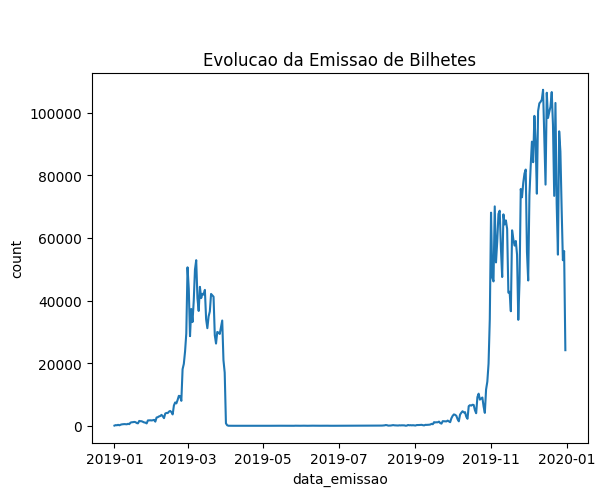

In [42]:
lineplot(ranking_data_emissao, '\n\nEvolucao da Emissao de Bilhetes','data_emissao', 'count', 'Fig2.png')

# Bilhetes emitidos por Mês

In [43]:
ranking_mes_emissao = df_viagem_2019.groupBy('mes_emissao').count().orderBy('mes_emissao',ascending=True).toPandas()

In [44]:
dict_mes = {1:'Janeiro', 2:'Fevereiro', 3:'Marco', 4:'Abril', 5:'Maio', 6:'Junho', 7:'Julho', 8:'Agosto', 9:'Setembro', 10:'Outubro', 11:'Novembro', 12:'Dezembro'}

In [45]:
lista_mes =[]
for i in ranking_mes_emissao.mes_emissao:
  lista_mes.append(dict_mes.get(i))
ranking_mes_emissao['mes'] = lista_mes

In [46]:
ranking_mes_emissao

,mes_emissao,count,mes
0,1,27654,Janeiro
1,2,202288,Fevereiro
2,3,1135554,Marco
3,4,1007,Abril
4,5,325,Maio
5,6,419,Junho
6,7,503,Julho
7,8,3716,Agosto
8,9,24224,Setembro
9,10,220250,Outubro




	2019
	Total Emissao por Mês

           mes    count
0     Janeiro    27654
1   Fevereiro   202288
2       Marco  1135554
3       Abril     1007
4        Maio      325
5       Junho      419
6       Julho      503
7      Agosto     3716
8    Setembro    24224
9     Outubro   220250
10   Novembro  1783562
11   Dezembro  2625803


<Figure size 2000x1000 with 0 Axes>

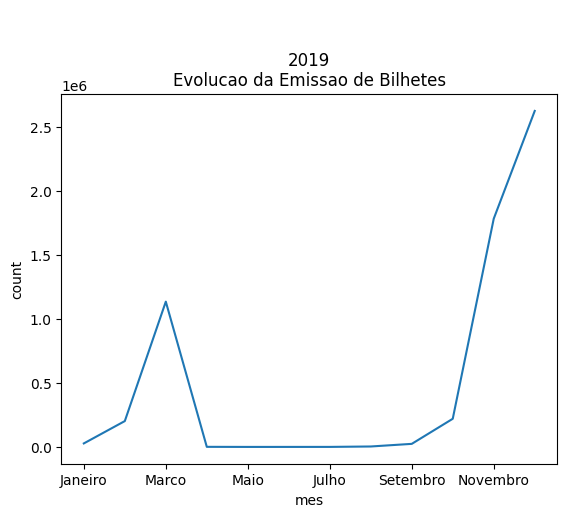

In [47]:
print('\033[1m'+'\n\n\t2019\n\tTotal Emissao por Mês\n\n',ranking_mes_emissao[['mes','count']])
lineplot(ranking_mes_emissao,'\n\n2019\nEvolucao da Emissao de Bilhetes', 'mes', 'count', 'Fig3.png')

 

	2019
	Total Emissao por Mês

           mes    count
0     Janeiro    27654
1   Fevereiro   202288
2       Marco  1135554
3       Abril     1007
4        Maio      325
5       Junho      419
6       Julho      503
7      Agosto     3716
8    Setembro    24224
9     Outubro   220250
10   Novembro  1783562
11   Dezembro  2625803


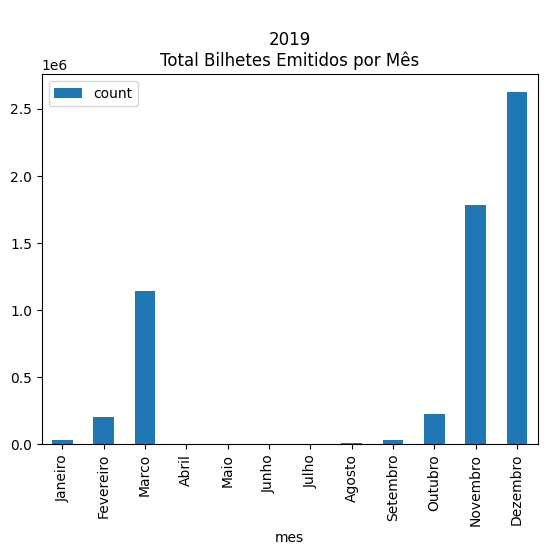

In [48]:
print('\033[1m','\n\n\t2019\n\tTotal Emissao por Mês\n\n',ranking_mes_emissao[['mes','count']])
ranking_mes_emissao.plot(x='mes', y='count', kind='bar', title='\n2019\nTotal Bilhetes Emitidos por Mês')
plt.savefig('Fig4.png', bbox_inches='tight')
plt.show();

# Bilhetes emitidos por Dia da Semana

In [49]:
ranking_dia_emissao = df_viagem_2019.groupBy('dia_da_semana').count().orderBy('count',ascending=False).toPandas()

In [50]:
#ranking_dia_emissao['count(k)'] = ranking_dia_emissao['count']/1000

In [51]:
ranking_dia_emissao

,dia_da_semana,count
0,6,1070145
1,1,1006129
2,2,876567
3,7,874909
4,5,794954
5,4,707090
6,3,695511


In [52]:
dict_dias = {1:'Domingo', 2:'Segunda-feira', 3:'Terca-feira', 4:'Quarta-feira', 5:'Quinta-feira', 6:'Sexta-feira', 7:'Sabado'}

In [53]:
lista_dia =[]
for i in ranking_dia_emissao.dia_da_semana:
  lista_dia.append(dict_dias.get(i))
ranking_dia_emissao['dia_semana'] = lista_dia

In [54]:
ranking_dia_emissao

,dia_da_semana,count,dia_semana
0,6,1070145,Sexta-feira
1,1,1006129,Domingo
2,2,876567,Segunda-feira
3,7,874909,Sabado
4,5,794954,Quinta-feira
5,4,707090,Quarta-feira
6,3,695511,Terca-feira




	2019
	TOTAL BILHETES POR DIA DA SEMANA

       dia_semana    count
0    Sexta-feira  1070145
1        Domingo  1006129
2  Segunda-feira   876567
3         Sabado   874909
4   Quinta-feira   794954
5   Quarta-feira   707090
6    Terca-feira   695511


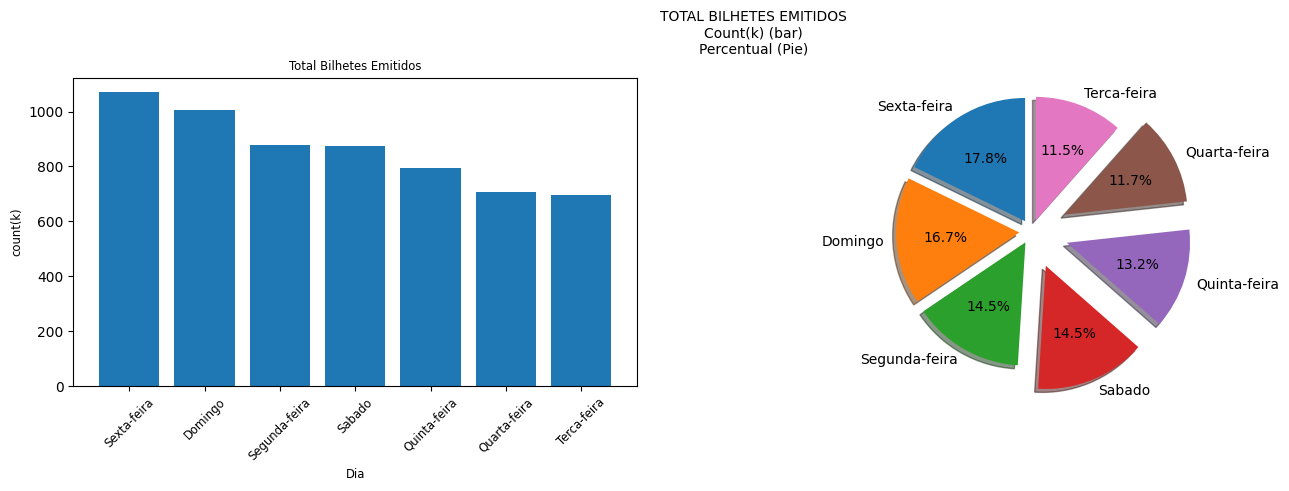

In [55]:

ranking_days = ranking_dia_emissao.copy()
ranking_days['count(k)'] = ranking_days['count']/1000


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.25))

plot0 =   axs[0].bar(x=ranking_days['dia_semana']
                     , height=ranking_days['count(k)'])
title0 =  axs[0].set_title('Total Bilhetes Emitidos', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Dia', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('count(k)', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(ranking_days['dia_semana']
                                       ,rotation = 45, fontsize='small')

explode = (0.1,0.1,0.1, 0.3, 0.3, 0.3, 0.1)
#title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=ranking_days['count']
    , labels=ranking_days['dia_semana']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
);

text = fig.text(0.55, 1.05, 'TOTAL BILHETES EMITIDOS\nCount(k) (bar)\nPercentual (Pie)', ha='center', va='top', transform=fig.transFigure);
print('\033[1m'+'\n\n\t2019\n\tTOTAL BILHETES POR DIA DA SEMANA\n\n',ranking_days[['dia_semana', 'count']])
plt.savefig('Fig5.png', bbox_inches='tight')

# Criar coluna UF para analisar o fluxo entre Ufs.

In [56]:
df_viagem_2019.select('origem_destino_linha').show(5)

+--------------------+
|origem_destino_linha|
+--------------------+
|FLORIANOPOLIS(SC)...|
|FLORIANOPOLIS(SC)...|
|BALNEARIO CAMBORI...|
|FLORIANOPOLIS(SC)...|
|BALNEARIO CAMBORI...|
+--------------------+
only showing top 5 rows



In [57]:
ranking_linha = df_viagem_2019.groupBy('origem_destino_linha').count().orderBy('count',ascending=False).toPandas()

In [58]:
linha= ranking_linha.origem_destino_linha.str.split('-', expand=True)

In [59]:
origem_linha = linha[0]
destino_linha = linha[1]

# Extrair UF origem da linha

In [60]:
split_col = pyspark.sql.functions.split(df_viagem_2019['origem_destino_linha'], '-')
df_viagem_2019 = df_viagem_2019.withColumn('origem_linha', split_col.getItem(0))
#df_viagem_2019 = df_viagem_2019.withColumn('destino_linha', split_col.getItem(1))
#
split_col = pyspark.sql.functions.split(df_viagem_2019['origem_linha'], '\\(')
df_viagem_2019 = df_viagem_2019.withColumn('uf_origem', split_col.getItem(1))
#
split_col = pyspark.sql.functions.split(df_viagem_2019['uf_origem'], '\\)')
df_viagem_2019 = df_viagem_2019.withColumn('uf_origem', split_col.getItem(0))

# Extrair UF destino da linha

In [61]:
split_col = pyspark.sql.functions.split(df_viagem_2019['origem_destino_linha'], '-')
#df_viagem_2019 = df_viagem_2019.withColumn('origem_linha', split_col.getItem(0))
df_viagem_2019 = df_viagem_2019.withColumn('destino_linha', split_col.getItem(1))
#
split_col = pyspark.sql.functions.split(df_viagem_2019['destino_linha'], '\\(')
df_viagem_2019 = df_viagem_2019.withColumn('uf_destino', split_col.getItem(1))
#
split_col = pyspark.sql.functions.split(df_viagem_2019['uf_destino'], '\\)')
df_viagem_2019 = df_viagem_2019.withColumn('uf_destino', split_col.getItem(0))

In [62]:
df_viagem_2019.select('origem_destino_linha','origem_linha','uf_origem', 'destino_linha','uf_destino').show(3)

+--------------------+--------------------+---------+--------------+----------+
|origem_destino_linha|        origem_linha|uf_origem| destino_linha|uf_destino|
+--------------------+--------------------+---------+--------------+----------+
|FLORIANOPOLIS(SC)...|  FLORIANOPOLIS(SC) |       SC| SAO PAULO(SP)|        SP|
|FLORIANOPOLIS(SC)...|  FLORIANOPOLIS(SC) |       SC|  CAMPINAS(SP)|        SP|
|BALNEARIO CAMBORI...|BALNEARIO CAMBORI...|       SC| SAO PAULO(SP)|        SP|
+--------------------+--------------------+---------+--------------+----------+
only showing top 3 rows



# Checkpoint
# Ponto de salvamento do dataset gerado.

In [63]:
# Checkpoint do dataset gerado
df_viagem_2019.write.parquet("df_viagem_2019.parquet", mode='overwrite')
df_viagem_2019 =spark.read.parquet("df_viagem_2019.parquet")

In [64]:
ranking_uf_origem = df_viagem_2019.groupBy('uf_origem').count().orderBy('count',ascending=False).toPandas()

# Total de Bilhetes Emitidos por UF



2019
TOTAL BILHETES POR UF Origem

   uf_origem    count
0        SP  1018483
1        PR   905240
2        MG   856375
3        BA   518057
4        GO   425053
5        ES   387960
6        RJ   333020
7        SC   275518
8        CE   214165
9        RS   185184


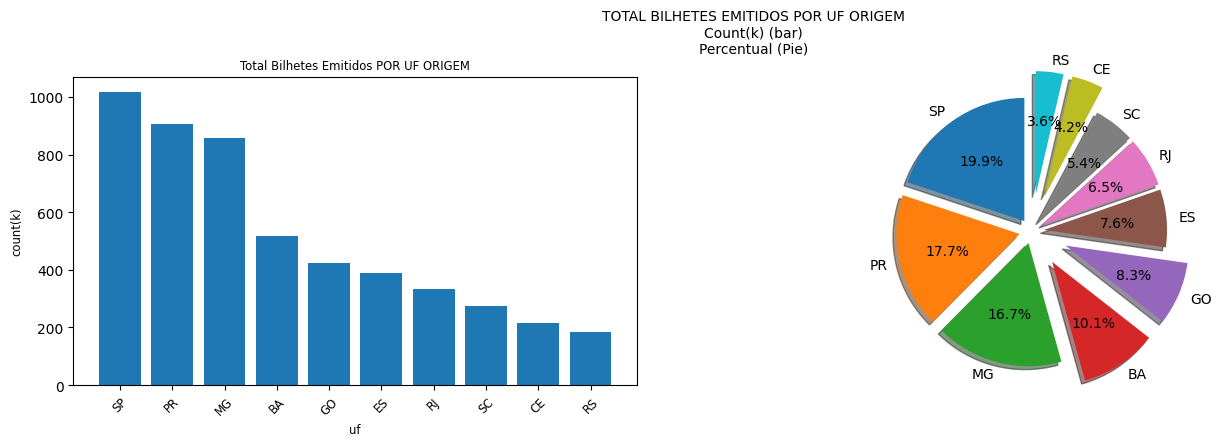

In [65]:

top10_uf_orig = ranking_uf_origem[:10].copy()
top10_uf_orig['count(k)'] = top10_uf_orig['count']/1000

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.25))

plot0 =   axs[0].bar(x=top10_uf_orig['uf_origem']
                     , height=top10_uf_orig['count(k)'])
title0 =  axs[0].set_title('Total Bilhetes Emitidos POR UF ORIGEM', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('uf', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('count(k)', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(top10_uf_orig['uf_origem']
                                       ,rotation = 45, fontsize='small')

explode = (0.1,0.1,0.1, 0.3, 0.3,0.1,0.1,0.1, 0.3, 0.3)
#title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=top10_uf_orig['count']
    , labels=top10_uf_orig['uf_origem']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
);

text = fig.text(0.55, 1.05, 'TOTAL BILHETES EMITIDOS POR UF ORIGEM\nCount(k) (bar)\nPercentual (Pie)', ha='center', va='top', transform=fig.transFigure);
print('\033[1m'+'\n\n2019\nTOTAL BILHETES POR UF Origem\n\n',top10_uf_orig[['uf_origem', 'count']])
plt.savefig('Fig6.png', bbox_inches='tight')

# Dados estatisticos por cidade destino
- valor_total
- count
- min
-max
-avg

In [66]:
#df_viagem_2019.columns

In [67]:
df_destino = df_viagem_2019.groupBy("ponto_destino_viagem") \
    .agg(sum("valor_total").alias("sum_valor_total"), \
         avg("valor_total").alias("avg_valor_total"), \
         min("valor_total").alias("min_valor_total"), \
         max("valor_total").alias("max_valor_total"), \
         count("*").alias("count")\
          ).orderBy('count',ascending=False).toPandas()

# Identificar por cidade destino
- Valor_total - é o valor considerando o custo da passagem mais impostos.
>sum
>avg
>min
>max
>count

In [130]:
destino_cols = df_destino.columns.to_list()
temp1 = df_destino[destino_cols]
@interact
def filter_destino(Destino = list(temp1.ponto_destino_viagem.unique())):

    print('\033[1m'+"\n\n\tValor_total:\n\tsum,avg, min, max e count")

    filter = df_destino.loc[temp1.ponto_destino_viagem == Destino]
    display(filter)
    print('\n')
    print('\033[1m'+"\tObservação:\n\tO valor  min_valor_total igual a 0.0 corresponde ao uso de algum tipo de beneficio social.\n\tPor exemplo, passagem do idoso.\n\n")
    return


interactive(children=(Dropdown(description='Destino', options=('SAO PAULO/SP', 'RIO DE JANEIRO/RJ', 'CURITIBA/…

# Total de Bilhetes Emitidos por UF

In [69]:
temp_uf = df_viagem_2019.select('uf_origem', 'uf_destino').toPandas()
#
temp_uf = temp_uf[['uf_origem', 'uf_destino']].value_counts().reset_index(name='count')
temp_uf['total_uf_orig'] = temp_uf.groupby('uf_origem')['count'].transform('sum')
temp_top10 = temp_uf[['uf_origem', 'total_uf_orig']].drop_duplicates().sort_values(by='total_uf_orig', ascending=False)
temp_top10 = temp_top10[:10]

# Banderias dos Estados

In [70]:
rj = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_Rio_de_Janeiro.png')
ba = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_da_Bahia.png')
pb = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_da_Paraíba.png')
al = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Alagoas.png')
#
go = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Goiás.png')
mg = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Minas_Gerais.png')
pe = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Pernambuco.png')
ro = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Rondônia.png')
#
rr = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Roraima.png')
sc = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Santa_Catarina.png')
se = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Sergipe.png')
ac = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Acre.png')
#
ap = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Amapa.png')
am = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Amazonas.png')
ce = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Ceara.png')
df = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Distrito_Federal_Brasil.png')
#
es = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Espírito_Santo.png')
ma = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Maranhao.png')
pa = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Para.png')
pr = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Parana.png')
#
pi = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Piaui.png')
rn = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Rio_Grande_do_Norte.png')
rs = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Rio_Grande_do_Sul.png')
to = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_do_Tocantins.png')
#
sp = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_Sao_Paulo.png')
ms = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_Mato_Grosso_do_Sul.png')
mt = Image.open('/content/drive/MyDrive/Viagens/Bandeiras_Br/Bandeira_de_Mato_Grosso.png')

#
dict_icons = {'RJ':rj, 'BA':ba, 'PB':pb, 'AL':al, 'GO':go, 'MG':mg, 'PE':pe, 'RO': ro, 'RR':rr, 'SC': sc, 'SE': se, 'AC':ac, 'AP':ap, 'AM': am, 'CE':ce, 'DF':df,
              'ES': es, 'MA':ma, 'PA': pa, 'PR': pr, 'PI':pi, 'RN': rn, 'RS': rs, 'TO':to, 'SP':sp, 'MS':ms, 'MT':mt}
#
#
height = temp_top10['total_uf_orig'].reset_index(drop=True)
#
X = np.arange(len(height))

In [71]:
def plot_uf():
  fig = plt.figure(figsize=(7, 2.5), dpi = 200, facecolor = "#EFE9E6")
  ax = plt.subplot(111, facecolor = "#EFE9E6", ylabel='')

  plt.ylabel("total bilhetes")
  plt.xlabel('uf')

  plt.title("Top 10\nTotal de Bilhetes Emitidos por UF\nPeriodo: 2019\n")

  # ax1 = plt.axes()
  # y_axis = ax1.axes.get_yaxis()
  # y_axis.set_visible(False)

  # Add spines
  ax.spines["top"].set(visible = False)
  ax.spines["right"].set(visible = False)

  # Add grid and axis labels
  ax.grid(True, color = "lightgrey", ls = ":")

  # We specify the width of the bar
  width = 0.5

  # Fouls conceded
  ax.bar(
    X,
    height,
    ec = "black",
    lw = .9,
    color = "#005a9b",
    zorder = 3,
    width = width
  )

  for index, y in enumerate(height):
    ax.annotate(
        xy = (index, y),
        text = f"{y}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 8,
        color = "black",# "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

  xticks_ = ax.xaxis.set_ticks(
    ticks = X,
    labels = []
  )
  yticks_ = ax.yaxis.set_ticks(
    ticks = [],
    labels = []
  )

  ax.tick_params(labelsize = 6)


  # --- Axes transformations

  DC_to_FC = ax.transData.transform
  FC_to_NFC = fig.transFigure.inverted().transform

  # Native data to normalized data coordinates
  DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

  for index, uf in enumerate(temp_top10["uf_origem"]):
    ax_coords = DC_to_NFC([index - width/2, -0.005])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.07, 0.07], anchor = "W")
    uf_icon = dict_icons.get(uf)
    logo_ax.imshow(uf_icon)
    logo_ax.axis("off")

    logo_ax.annotate(
        xy =(0, 0),
        text = f"{temp_top10['uf_origem'].iloc[index]}",
        xytext = (8.5, -23.5), # (x,y) x é a posicao relativa ao eixo vertical e y eixo horizontal onde aparece o icone da UF
        textcoords = "offset points",
        size = 7,
        ha = "center",
        va = "center"
    )


  plt.subplots_adjust(top=0.70)
  plt.savefig("\nTop10_Total_Bilhetes_por_UF.png")
  plt.savefig("Fig7.png", bbox_inches='tight')


  plt.show()

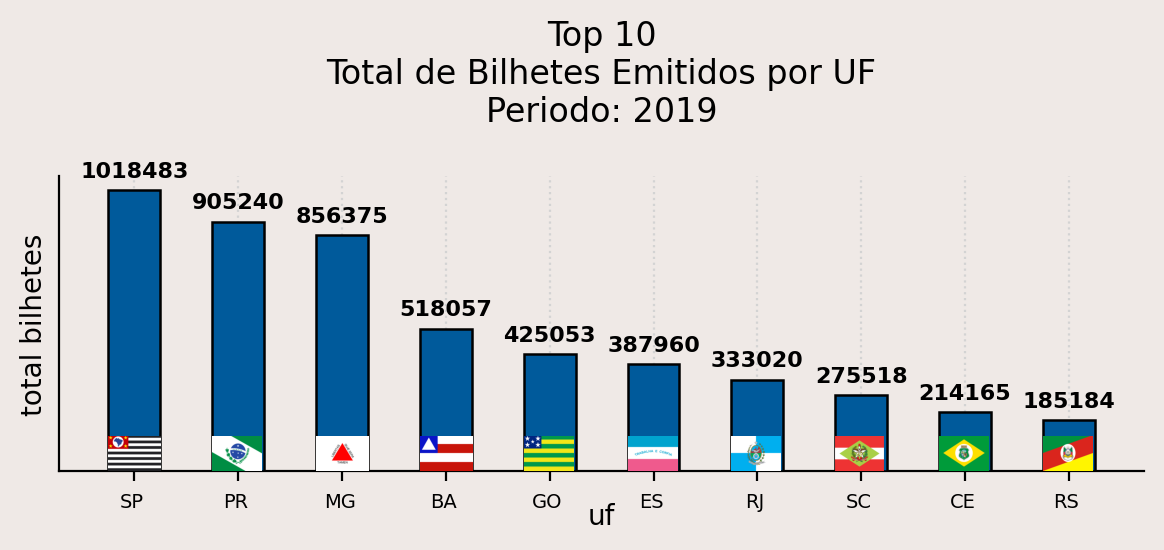

In [72]:
plot_uf()

# Fluxo de Viagens Entre UFs
- gráfico de barras

In [73]:
#df_temp = df_viagem_2019.select('uf_origem', 'uf_destino').toPandas()
#df_uf3 = df_temp[['uf_origem', 'uf_destino']].value_counts().reset_index(name='count')

df_uf3 = temp_uf
#
df_uf3['ufs'] = df_uf3.uf_origem+'-->'+df_uf3.uf_destino

       ufs   count
0  SP-->RJ  434482
1  SP-->MG  399860
2  PR-->SP  389775
3  PR-->SC  360121
4  MG-->RJ  356271
5  MG-->SP  330311
6  RJ-->SP  268510
7  ES-->MG  262390
8  BA-->SP  166246
9  SP-->PR  141446


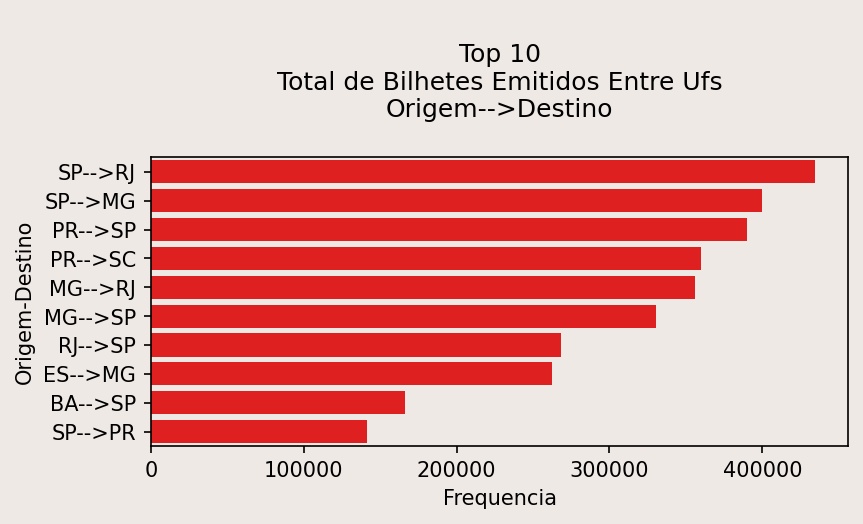

In [74]:
import seaborn as sns
fig = plt.figure(figsize=(6, 2.5), dpi = 150, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")
temp_fig7 = df_uf3[['ufs', 'count']].iloc[:10]
print(temp_fig7)
#temp.plot.bar(x = 'ufs' , y= 'count', edgecolor='black', rot=80, color='red');
sns.barplot(x=temp_fig7['count'], y=temp_fig7['ufs'], orient='h', color='red')
plt.xlabel('Frequencia')
plt.ylabel('Origem-Destino')
plt.title("\nTop 10\nTotal de Bilhetes Emitidos Entre Ufs\nOrigem-->Destino\n");
plt.savefig("Fig7.png",  bbox_inches='tight');

# Fluxo de Viagens entre UFs
- grafico sankey
- https://python-graph-gallery.com/basic-sankey-diagram-with-pysankey/

In [75]:
filter=10000
df_filtered = temp_uf.loc[temp_uf['count']>= filter].sort_values(by='count', ascending=False)
df_filtered

,uf_origem,uf_destino,count,total_uf_orig,ufs
0,SP,RJ,434482,1018483,SP-->RJ
1,SP,MG,399860,1018483,SP-->MG
2,PR,SP,389775,905240,PR-->SP
3,PR,SC,360121,905240,PR-->SC
4,MG,RJ,356271,856375,MG-->RJ
...,...,...,...,...,...
81,CE,SE,10597,214165,CE-->SE
82,GO,RJ,10507,425053,GO-->RJ
83,MS,RJ,10324,146242,MS-->RJ
84,AL,BA,10265,112764,AL-->BA




Top 5
Fluxo entre UFs

        ufs   count
0  SP-->RJ  434482
1  SP-->MG  399860
2  PR-->SP  389775
3  PR-->SC  360121
4  MG-->RJ  356271 



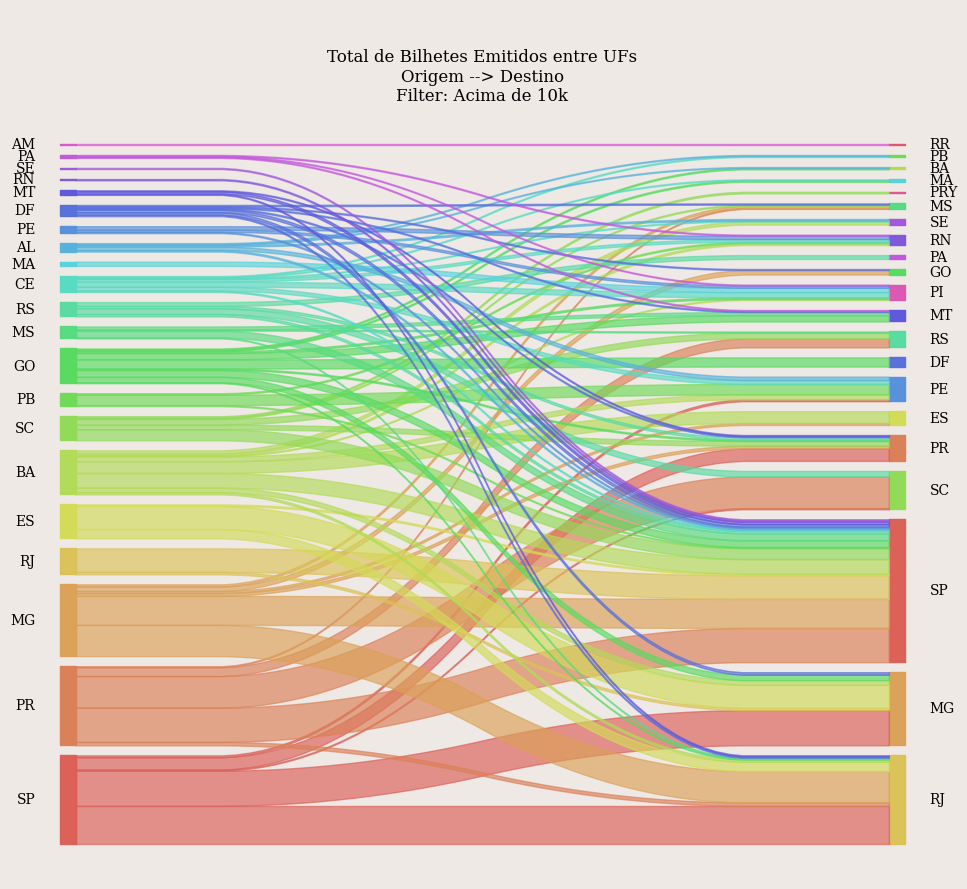

In [76]:
sankey(
    left=df_filtered["uf_origem"], right=df_filtered["uf_destino"],
    leftWeight= df_filtered["count"], rightWeight=df_filtered["count"],
    aspect=20, fontsize=10
)

# Get current figure
fig = plt.gcf()



# Set size in inches
fig.set_size_inches(12, 10)

temp_fig8 = df_filtered[['ufs', 'count']]
print('\n\nTop 5\nFluxo entre UFs\n\n',temp_fig8[:5],'\n')
# Set the color of the background to white
fig.set_facecolor("#EFE9E6")
plt.title("\n\nTotal de Bilhetes Emitidos entre UFs\nOrigem --> Destino\nFilter: Acima de 10k");
# Save the figure
plt.subplots_adjust(top=0.88)
fig.savefig("fluxo_passageiros.png", bbox_inches="tight", dpi=180)
plt.savefig("Fig8.png",  bbox_inches='tight');



![](https://drive.google.com/uc?export=view&id=1uRhFT-YkC2B2VHM9FAi-U5Sofkdu7zNU)


# **Análises com base nos gráficos gerados**

 

São Paulo representa 13% do fluxo de passageiros no país.
De São Paulo pessoas partem para outros Estados ou países.


2019
Top 5 destinos

   ponto_destino_viagem  percentual
0         SAO PAULO/SP       13.23
1    RIO DE JANEIRO/RJ        8.07
2          CURITIBA/PR        4.85
3    BELO HORIZONTE/MG        3.82
4           GOIANIA/GO        2.13
5      Outros Destinos       67.90


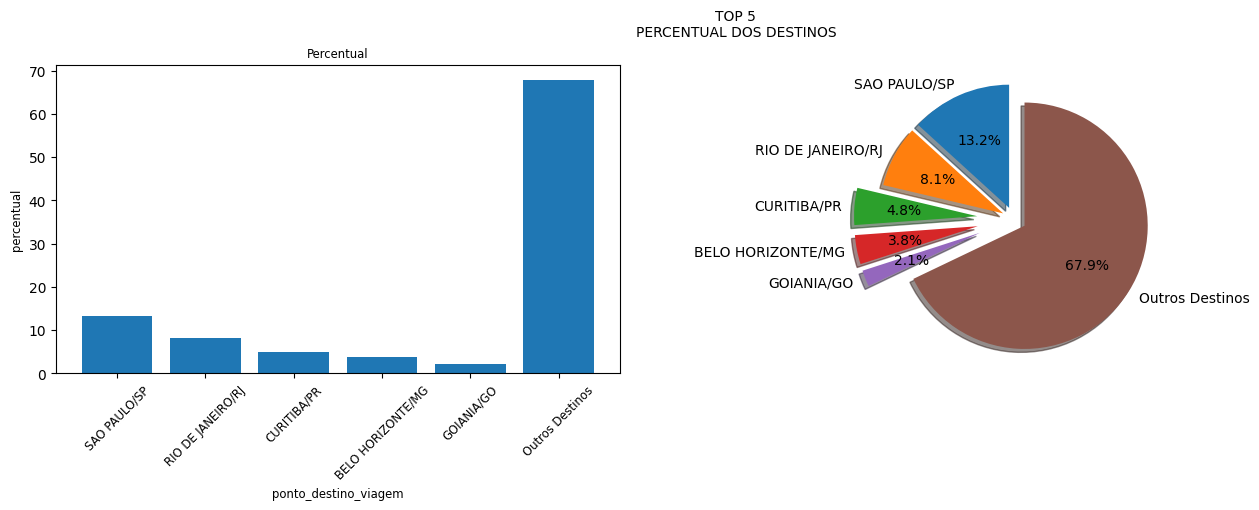

In [131]:
# Fig1
print('\033[1m',"\n\nSão Paulo representa 13% do fluxo de passageiros no país.\nDe São Paulo pessoas partem para outros Estados ou países.\n")
fig = Image.open(r'/content/Fig1.png')
print('\033[1m'+'\n2019\nTop 5 destinos\n\n',temp_fig1)
fig


 

Março, Novembro de Dezembro apresentam picos de grande fluxo,
provavelmente devido ao periodo de carnaval e natal.



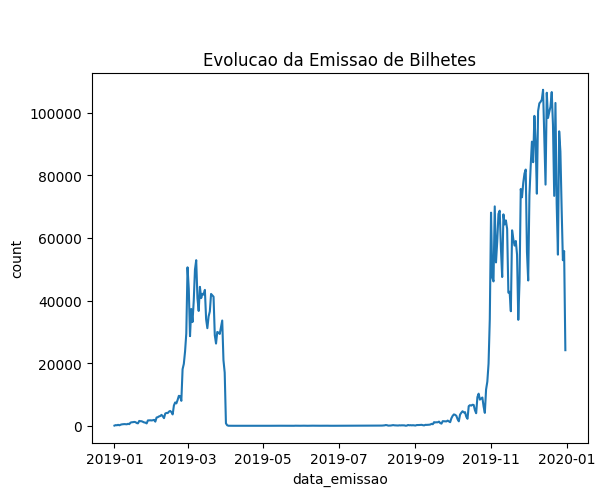

In [129]:
# Fig2
print('\033[1m',"\n\nMarço, Novembro de Dezembro apresentam picos de grande fluxo,\nprovavelmente devido ao periodo de carnaval e natal.\n")
#print('\033[1m',ranking_data_emissao[:10])
fig = Image.open(r'/content/Fig2.png')
fig

 

De Maio até Julho os valores são bem menores.

2019
Total Emissao por Mês

           mes    count
0     Janeiro    27654
1   Fevereiro   202288
2       Marco  1135554
3       Abril     1007
4        Maio      325
5       Junho      419
6       Julho      503
7      Agosto     3716
8    Setembro    24224
9     Outubro   220250
10   Novembro  1783562
11   Dezembro  2625803


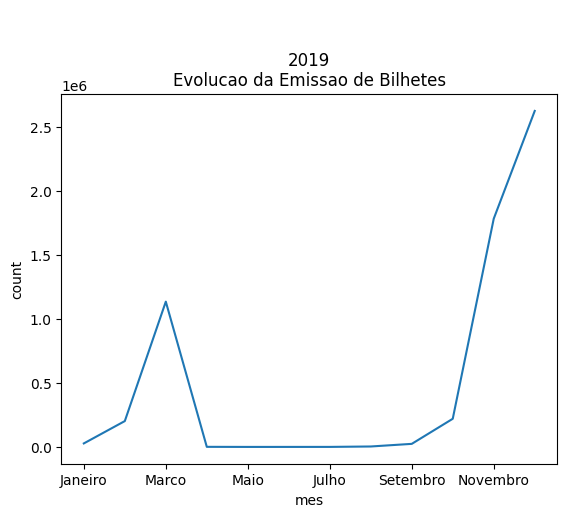

In [79]:
# Fig3
print('\033[1m',"\n\nDe Maio até Julho os valores são bem menores.\n")
print('\033[1m'+'2019\nTotal Emissao por Mês\n\n',ranking_mes_emissao[['mes','count']])
fig = Image.open(r'/content/Fig3.png')
fig

 

Dezembro e Novembro são bem movimentados devido ao periodo natalino.
Março pode ter sido o periodo do carnaval.

 
2019
Total Emissao por Mês

           mes    count
0     Janeiro    27654
1   Fevereiro   202288
2       Marco  1135554
3       Abril     1007
4        Maio      325
5       Junho      419
6       Julho      503
7      Agosto     3716
8    Setembro    24224
9     Outubro   220250
10   Novembro  1783562
11   Dezembro  2625803


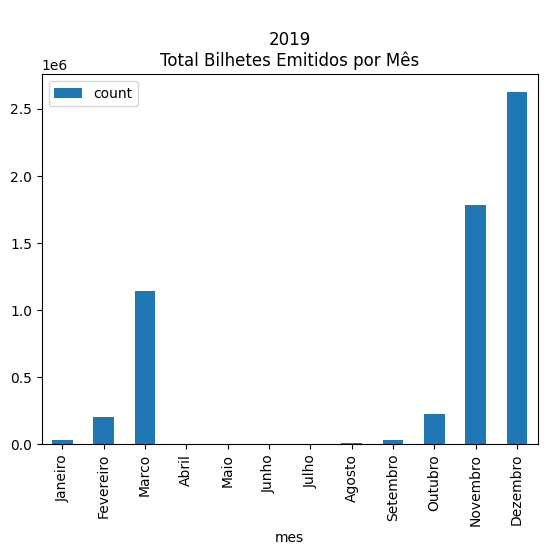

In [80]:
# Fig4
print('\033[1m',"\n\nDezembro e Novembro são bem movimentados devido ao periodo natalino.\nMarço pode ter sido o periodo do carnaval.\n")
print('\033[1m','\n2019\nTotal Emissao por Mês\n\n',ranking_mes_emissao[['mes','count']])
fig = Image.open(r'/content/Fig4.png')
fig

 

Sexta-feira e Domingo apresentam os maiores valores de bilhetes emitidos.
Podem ser pessoas partindo pro fim de semana ou aproveitando feriados prolongados.


2019
TOTAL BILHETES POR DIA DA SEMANA

       dia_semana    count
0    Sexta-feira  1070145
1        Domingo  1006129
2  Segunda-feira   876567
3         Sabado   874909
4   Quinta-feira   794954
5   Quarta-feira   707090
6    Terca-feira   695511


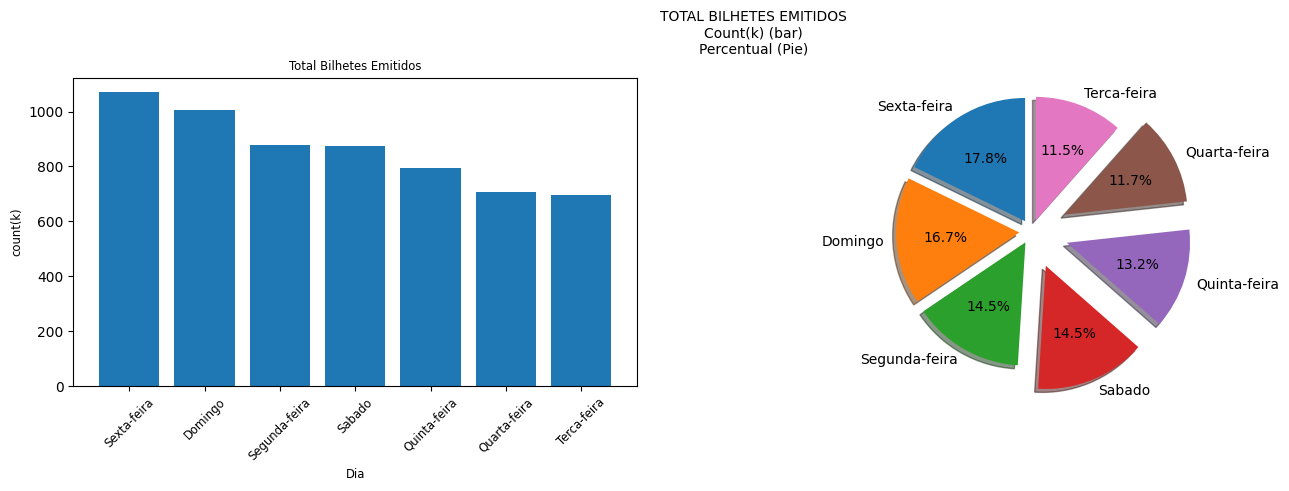

In [81]:
# Fig5
print('\033[1m',"\n\nSexta-feira e Domingo apresentam os maiores valores de bilhetes emitidos.\nPodem ser pessoas partindo pro fim de semana ou aproveitando feriados prolongados.\n")
print('\033[1m'+'\n2019\nTOTAL BILHETES POR DIA DA SEMANA\n\n',ranking_days[['dia_semana', 'count']])
fig = Image.open(r'/content/Fig5.png')
fig

 

O Estado de São Paulo apresenta o maior fluxo de passageiros partindo para outros destinos.
Isto pode ser explicado devido a grande quantidade de pessoas vindas de outros Estados morando em São Paulo.


2019
TOTAL BILHETES POR UF Origem

   uf_origem    count
0        SP  1018483
1        PR   905240
2        MG   856375
3        BA   518057
4        GO   425053
5        ES   387960
6        RJ   333020
7        SC   275518
8        CE   214165
9        RS   185184


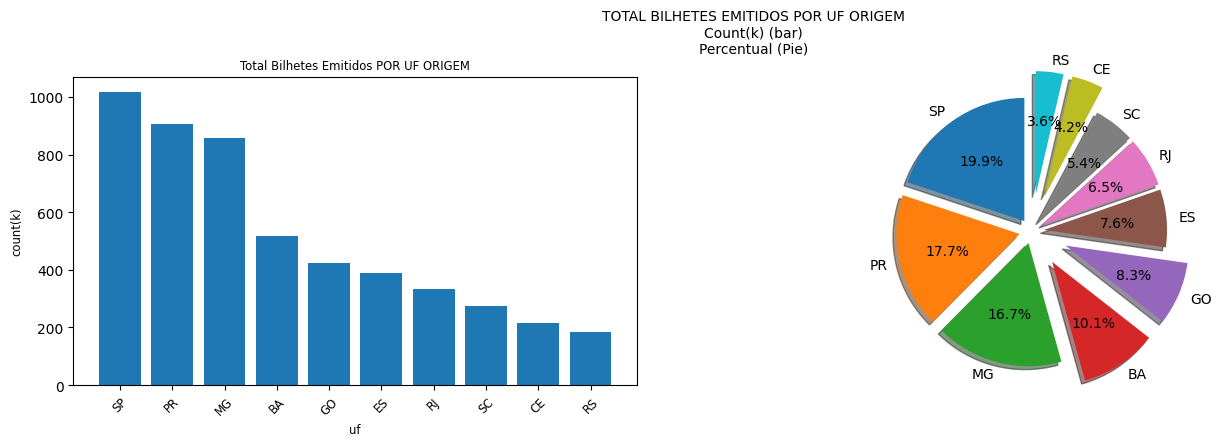

In [82]:
# Fig6
print('\033[1m',"\n\nO Estado de São Paulo apresenta o maior fluxo de passageiros partindo para outros destinos.\nIsto pode ser explicado devido a grande quantidade de pessoas vindas de outros Estados morando em São Paulo.\n")
print('\033[1m'+'\n2019\nTOTAL BILHETES POR UF Origem\n\n',top10_uf_orig[['uf_origem', 'count']])
fig = Image.open(r'/content/Fig6.png')
fig

 

São Paulo é o maior ponto de partida para os Estados do Rio de Janeiro e Minhas Gerais.
Os três maiores Estados da região sudeste.


2019
TOTAL BILHETES POR UF Origem

        ufs   count
0  SP-->RJ  434482
1  SP-->MG  399860
2  PR-->SP  389775
3  PR-->SC  360121
4  MG-->RJ  356271
5  MG-->SP  330311
6  RJ-->SP  268510
7  ES-->MG  262390
8  BA-->SP  166246
9  SP-->PR  141446 



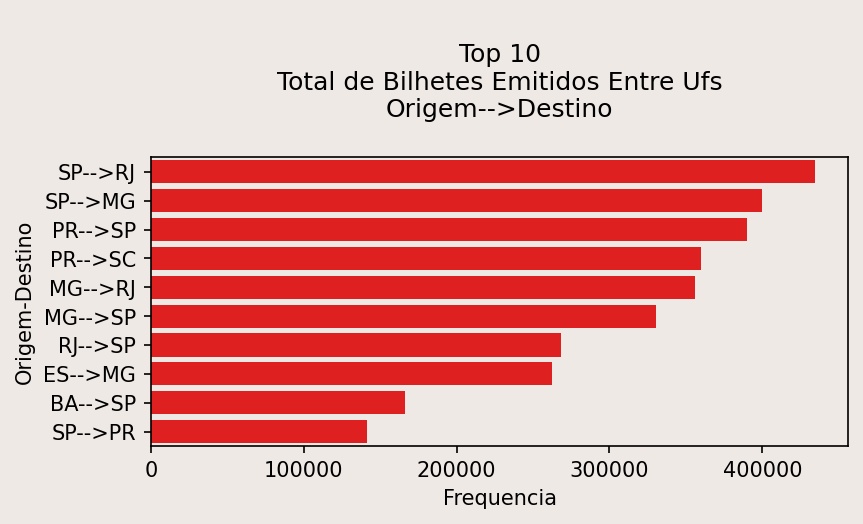

In [83]:
# Fig7
# df_uf.loc[df_uf['count']>= filter].sort_values(by='count', ascending=False)[['uf_origem_linha', 'uf_destino_linha', 'count']]
print('\033[1m',"\n\nSão Paulo é o maior ponto de partida para os Estados do Rio de Janeiro e Minhas Gerais.\nOs três maiores Estados da região sudeste.\n")
print('\033[1m'+'\n2019\nTOTAL BILHETES POR UF Origem\n\n',temp_fig7,'\n')
fig = Image.open(r'/content/Fig7.png')
fig

 

São Paulo é o Estado com maior fluxo de chega e partida de viajantes no país.
Maior cidade da América Latina.

Top 5 Fluxos entre UFs

        ufs   count
0  SP-->RJ  434482
1  SP-->MG  399860
2  PR-->SP  389775
3  PR-->SC  360121
4  MG-->RJ  356271 



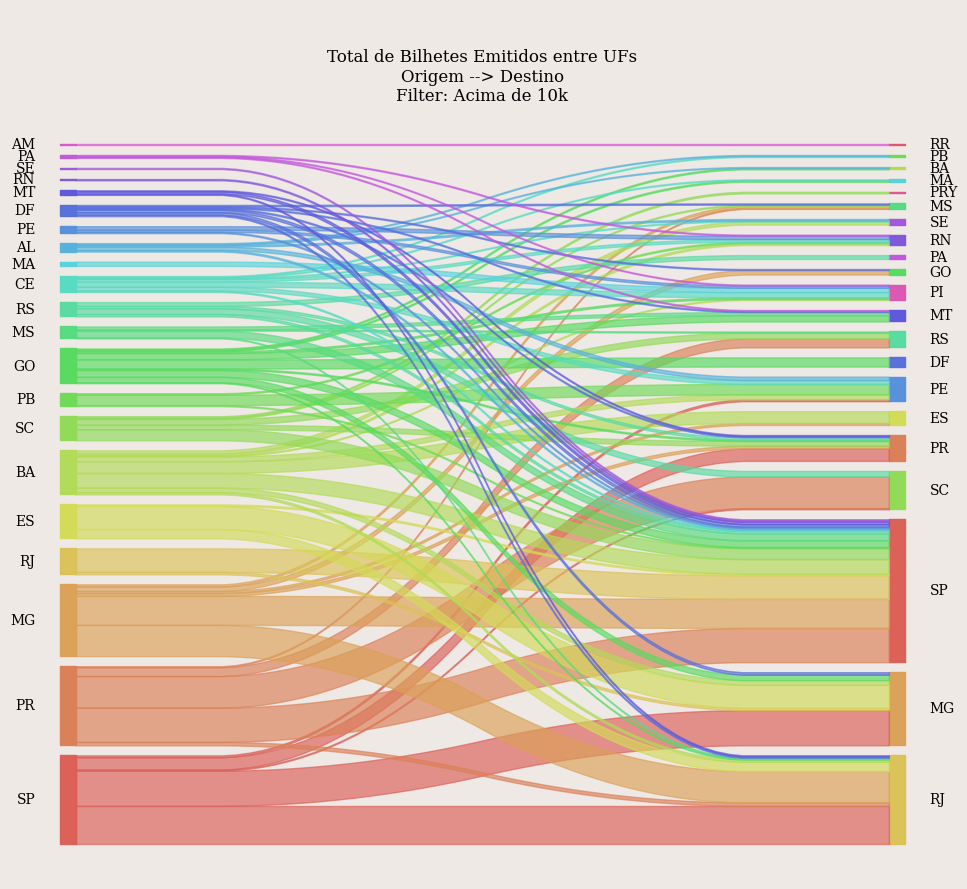

In [84]:
# Fig8
print('\033[1m',"\n\nSão Paulo é o Estado com maior fluxo de chega e partida de viajantes no país.\nMaior cidade da América Latina.\n")
print('\033[1m'+"Top 5 Fluxos entre UFs\n\n",temp_fig8[:5],'\n')
fig = Image.open(r'/content/Fig8.png')
fig

In [85]:
# Checkpoint do dataset gerado
#df_viagem_2019.write.parquet("df_viagem_2019.parquet", mode='overwrite')
df_viagem_2019 =spark.read.parquet("df_viagem_2019.parquet")

# Prever a Emissao de Bilhetes com o Prophet.

In [86]:
!pip install "holidays==0.24"
!pip install "prophet==1.1.1"

In [87]:
from datetime import date
from prophet import Prophet

# Foi usada apenas uma pequena parte do dados existentes.
# Foram selecionadas apenas as linhas com destino a SAO PAULO/SP.

In [88]:
df_sample = df_viagem_2019.sample(fraction=0.2)
#
df_filter = df_sample.select(*usecols).toPandas()
#
df_sp = df_filter.loc[df_filter.ponto_destino_viagem == 'SAO PAULO/SP']

In [89]:
df_filter.shape

(1205103, 12)

In [90]:
df_sp.shape

(160226, 12)

In [91]:
df_sp.head()

,data_emissao_bilhete,categoria_transporte,origem_destino_linha,ponto_origem_viagem,ponto_destino_viagem,tipo_servico,data_viagem,tipo_gratitude,tipo_viagem,numero_poltrona,valor_total,in_passagem_cancelada
8,2019-12-02,Interestadual,SANTO ANTONIO DA PLATINA(PR) - SAO PAULO(SP),SANTO ANTONIO DA PLATINA/PR,SAO PAULO/SP,Convencional com sanit�rio,2019-12-02,Tarifa Normal - sem desconto,Regular,32,108.77,N�O
12,2019-12-06,Interestadual,ARAPIRACA(AL) - SAO PAULO(SP),ARAPIRACA/AL,SAO PAULO/SP,Executivo,2019-12-17,"Tarifa Promocional - Par�grafo 3�, art. 27 do ...",Regular,15,274.03,N�O
37,2019-12-13,Interestadual,IBAITI(PR) - SAO PAULO(SP),CARLOPOLIS/PR,SAO PAULO/SP,Convencional com sanit�rio,2019-12-13,Tarifa Normal - sem desconto,Regular,20,110.80,N�O
60,2019-11-26,Interestadual,PARAIBA DO SUL(RJ) - SAO PAULO(SP),BARRA DO PIRAI/RJ,SAO PAULO/SP,Convencional com sanit�rio,2019-12-26,Tarifa Normal - sem desconto,Regular,15,90.71,N�O
63,2019-11-30,Interestadual,ITUIUTABA(MG) - SAO PAULO(SP),FRUTAL/MG,SAO PAULO/SP,Convencional com sanit�rio,2019-12-04,Tarifa Normal - sem desconto,Regular,19,133.74,N�O


In [92]:
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160226 entries, 8 to 1205100
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_emissao_bilhete   160226 non-null  datetime64[ns]
 1   categoria_transporte   160226 non-null  object        
 2   origem_destino_linha   160226 non-null  object        
 3   ponto_origem_viagem    160226 non-null  object        
 4   ponto_destino_viagem   160226 non-null  object        
 5   tipo_servico           160226 non-null  object        
 6   data_viagem            160226 non-null  datetime64[ns]
 7   tipo_gratitude         160226 non-null  object        
 8   tipo_viagem            160226 non-null  object        
 9   numero_poltrona        160226 non-null  int32         
 10  valor_total            160226 non-null  float64       
 11  in_passagem_cancelada  160226 non-null  object        
dtypes: datetime64[ns](2), float64(1), int32(1),

# O Prophet precisa de uma coluna ds que representa a data onde o evento ocorreu.
# E uma coluna y que representa as vendas ou emissões de bilhetes naquela data.
#
# Foi feito então um agrupamento pela coluna data_emissao_bilhete.
# Com isso foi gerada uma coluna y com a contagem de linhas por data.
# Assim y apresenta quantas vendas ou emissões de bilhetes foram feitas por dia.

In [93]:
import pandas as pd
# Tabela com acessos por mês e ano
# emissao_mensal = df_sp[['data_emissao_bilhete','count_emissao_dia']]\
#   .groupby(['data_emissao_bilhete'], as_index = True)\
#   .min()\
#   .reset_index()\
#   .sort_values(['data_emissao_bilhete'], ascending=True)\
#   .rename(columns={"data_emissao_bilhete": "ds", "count_emissao_dia": "y"})

emissao_mensal = pd.DataFrame(df_sp['data_emissao_bilhete'])
emissao_mensal['y'] = emissao_mensal.groupby(['data_emissao_bilhete'])['data_emissao_bilhete'].transform('count')
emissao_mensal = emissao_mensal.sort_values(by = 'data_emissao_bilhete', ascending=False).rename(columns={"data_emissao_bilhete": "ds"})

# Espiando o resultado do agrupamento
emissao_mensal.drop_duplicates(inplace=True)
emissao_mensal


,ds,y
164747,2019-12-31,269
203232,2019-12-30,900
141502,2019-12-29,989
550726,2019-12-28,1280
8655,2019-12-27,1534
...,...,...
1184648,2019-01-05,7
741369,2019-01-04,12
766465,2019-01-03,3
737012,2019-01-02,8


# Checar quantas emissões de bilhetes no dia.

In [94]:
temp_dia = df_filter.loc[df_filter.data_emissao_bilhete == '2019-12-31' ]
temp_dia.loc[temp_dia.ponto_destino_viagem == 'SAO PAULO/SP']

,data_emissao_bilhete,categoria_transporte,origem_destino_linha,ponto_origem_viagem,ponto_destino_viagem,tipo_servico,data_viagem,tipo_gratitude,tipo_viagem,numero_poltrona,valor_total,in_passagem_cancelada
163,2019-12-31,Interestadual,SAO PAULO(SP) - BELO HORIZONTE(MG),BELO HORIZONTE/MG,SAO PAULO/SP,Executivo,2019-12-31,"Tarifa Promocional - Par�grafo 3�, art. 27 do ...",Regular,29,133.73,N�O
345,2019-12-31,Interestadual,SAO PAULO(SP) - POCOS DE CALDAS(MG),POCOS DE CALDAS/MG,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,Tarifa Normal - sem desconto,Regular,26,73.99,N�O
2474,2019-12-31,Interestadual,SAO PAULO(SP) - CRUZILIA(MG),CAXAMBU/MG,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,Tarifa Normal - sem desconto,Regular,15,95.99,N�O
13794,2019-12-31,Interestadual,SAO PAULO(SP) - JUIZ DE FORA(MG),JUIZ DE FORA/MG,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,Tarifa Normal - sem desconto,Regular,27,154.99,N�O
23021,2019-12-31,Interestadual,BRASILIA(DF) - SAO PAULO(SP),BRASILIA/DF,SAO PAULO/SP,Executivo,2019-12-31,"Tarifa Promocional - Par�grafo 3�, art. 27 do ...",Regular,41,180.00,N�O
...,...,...,...,...,...,...,...,...,...,...,...,...
1200255,2019-12-31,Interestadual,PIUMHI(MG) - SAO PAULO(SP),CAPITOLIO/MG,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,"Tarifa Promocional - Par�grafo 3�, art. 27 do ...",Regular,3,0.00,N�O
1200920,2019-12-31,Interestadual,SAO PAULO(SP) - BELO HORIZONTE(MG),BELO HORIZONTE/MG,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,Tarifa Normal - sem desconto,Regular,21,0.00,N�O
1201931,2019-12-31,Interestadual,SAO PAULO(SP) - RIO DE JANEIRO(RJ),RIO DE JANEIRO/RJ,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,Tarifa Normal - sem desconto,Regular,15,125.99,N�O
1202185,2019-12-31,Interestadual,SAO PAULO(SP) - RIO DE JANEIRO(RJ),RIO DE JANEIRO/RJ,SAO PAULO/SP,Convencional com sanit�rio,2019-12-31,Tarifa Normal - sem desconto,Regular,15,125.99,N�O


In [95]:
emissao_mensal

,ds,y
164747,2019-12-31,269
203232,2019-12-30,900
141502,2019-12-29,989
550726,2019-12-28,1280
8655,2019-12-27,1534
...,...,...
1184648,2019-01-05,7
741369,2019-01-04,12
766465,2019-01-03,3
737012,2019-01-02,8


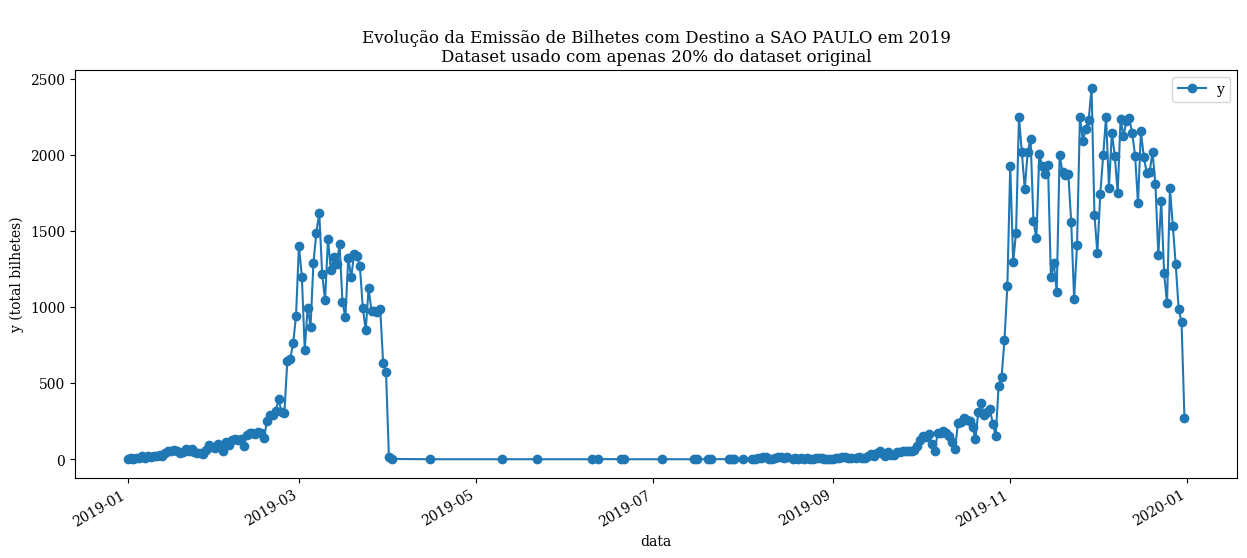

In [128]:
# Gerando o gráfico da série temporal
emissao_mensal.plot(x = 'ds', y = 'y', figsize = (15,6), marker='o');
plt.title("\nEvolução da Emissão de Bilhetes com Destino a SAO PAULO em 2019\nDataset usado com apenas 20% do dataset original");
plt.ylabel("y (total bilhetes)")
plt.xlabel("data")
plt.savefig("destino_sp.png",bbox_inches='tight');

In [97]:
# Instanciando o modelo
modelo = Prophet()

# Ajustando o modelo aos dados
modelo.fit(emissao_mensal)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5g9qu57/97nrc4t_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe5g9qu57/eil110go.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3707', 'data', 'file=/tmp/tmpe5g9qu57/97nrc4t_.json', 'init=/tmp/tmpe5g9qu57/eil110go.json', 'output', 'file=/tmp/tmpe5g9qu57/prophet_model2z4c7njv/prophet_model-20230727144548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Gráfico com a Previsão de Emissoes de Tickets com Destino a SAO PAULO/SP
# Periodo em meses.

 

	Predictions:
	_ y(future value)
	_ Trend
	_ Weakly


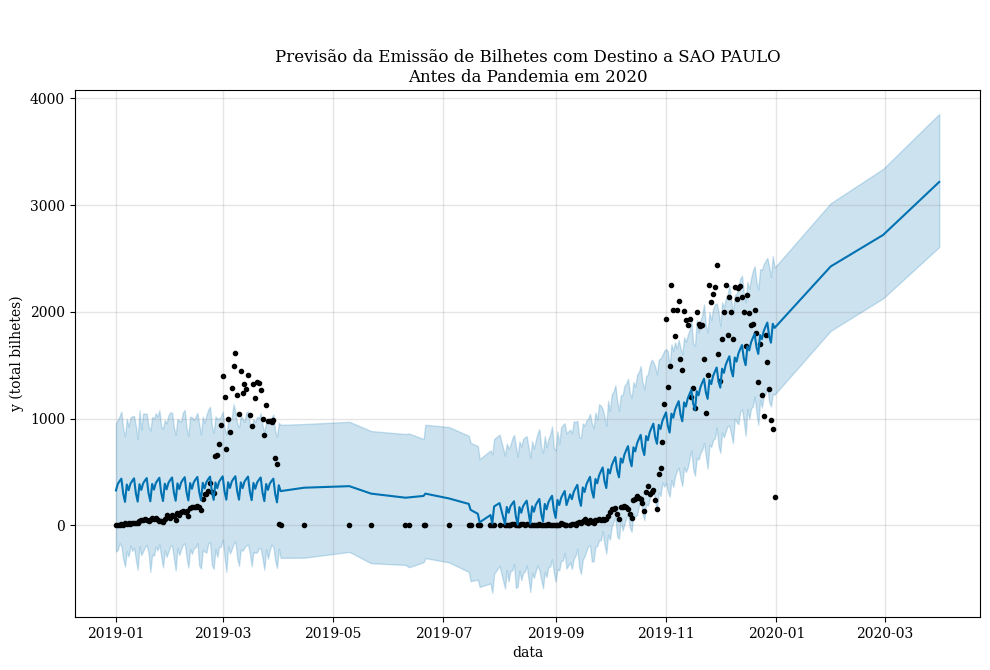

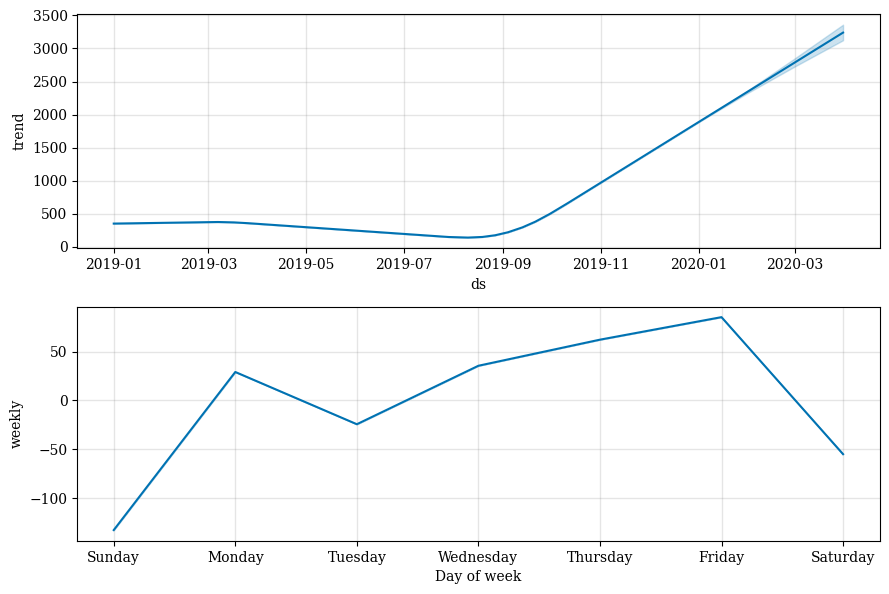

In [127]:
# Criando dataframe com os períodos futuros para as previsões
st_futuro = modelo.make_future_dataframe(
    periods= 3,
    freq = 'm', # day', 'week', 'month', 'quarter', 'year', 1(1 sec), 60(1 minute) or 3600(1 hour).
    include_history = True
)
#
# Realizando as previsões
previsao_Prophet = modelo.predict(st_futuro)
#
# Fazendo grafico da previsao
grafico_previsao_Prophet = modelo.plot(previsao_Prophet)
grafico_previsao_Prophet.show()
plt.title("\n\nPrevisão da Emissão de Bilhetes com Destino a SAO PAULO\nAntes da Pandemia em 2020");
plt.savefig("prophetplot1.png",bbox_inches='tight')
plt.ylabel("y (total bilhetes)")
plt.xlabel("data")
#
print('\033[1m',"\n\n\tPredictions:\n\t_ y(future value)\n\t_ Trend\n\t_ Weakly")
fig =  modelo.plot_components(previsao_Prophet)

fig.savefig("prophetplot2.png",bbox_inches='tight');